<a href="https://colab.research.google.com/github/kartickgupta/multilabel-news-classification/blob/main/Shared_Task_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install textaugment
import nltk
nltk.download('all')

     |████████████████████████████████| 55 kB 3.7 MB/s 
     |████████████████████████████████| 1.2 MB 19.0 MB/s 
     |████████████████████████████████| 42 kB 1.6 MB/s 
     |████████████████████████████████| 53 kB 2.8 MB/s 
     |████████████████████████████████| 65 kB 4.8 MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15734 sha256=358b13fe4701e27a1aa020b54402065b4c34b2e8abfa3d8137212a173406f0e6
  Stored in directory: /root/.cache/pip/wheels/20/da/eb/a54579056f265eede0417df537dd56d3df5b9eb2b25df0003d
Successfully built googletrans
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/bioc

True

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from google.colab import drive
from textaugment import Wordnet, EDA, word2vec, Translate
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
import gensim
import re
import matplotlib.pyplot as plt
import seaborn as sns
!pip3 install tensorflow_text
import tensorflow_text
!pip install -q tf-models-official
!pip install -q -U tensorflow-text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab
import tensorflow_hub as hub
import tensorflow_text as tf_text

     |████████████████████████████████| 4.3 MB 7.8 MB/s 
     |████████████████████████████████| 1.6 MB 8.4 MB/s 
     |████████████████████████████████| 37.1 MB 48 kB/s 
     |████████████████████████████████| 99 kB 12.5 MB/s 
     |████████████████████████████████| 679 kB 41.7 MB/s 
     |████████████████████████████████| 636 kB 47.3 MB/s 
     |████████████████████████████████| 54 kB 3.9 MB/s 
     |████████████████████████████████| 352 kB 69.5 MB/s 
     |████████████████████████████████| 1.2 MB 43.5 MB/s 
     |████████████████████████████████| 211 kB 73.9 MB/s 
     |████████████████████████████████| 43 kB 2.6 MB/s 


In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
with open('/content/drive/MyDrive/Shared-Task-2021/global-headline-only.csv', 'r') as f:
    df = pd.read_csv(f)

df.head()

,data_id,event_date,year,event_type,sub_event_type,region,country,location,notes,cleaned,lemmatized,stemmed
0,8378880,09-07-2021,2021,Explosions/Remote violence,Shelling/artillery/missile attack,Middle East,Syria,Arnaba,"On 9 July 2021, regime forces shelled Arnaba t...",regime forces shelled Arnaba town in Idleb cou...,regime force shelled arnaba town idleb country...,regim forc shell arnaba town idleb countrysid ...
1,8378881,09-07-2021,2021,Explosions/Remote violence,Shelling/artillery/missile attack,Middle East,Syria,Balyun,"On 9 July 2021, regime forces shelled Balyun t...",regime forces shelled Balyun town and its vici...,regime force shelled balyun town vicinity idle...,regim forc shell balyun town vicin idleb count...
2,8381441,09-07-2021,2021,Protests,Peaceful protest,East Asia,South Korea,Jinju,"On 9 July 2021, local veterans' organizations,...",local veterans organizations including the Kor...,local veteran organization including korean wa...,local veteran organ includ korean war veteran ...
3,8383746,09-07-2021,2021,Riots,Violent demonstration,South Asia,Pakistan,Larkana,"On 9 July 2021, prisoners held a demonstration...",prisoners held a demonstration and set wood an...,prisoner held demonstration set wood clothes f...,prison held demonstr set wood cloth fire larka...
4,8381699,09-07-2021,2021,Violence against civilians,Attack,Southeast Asia,Myanmar,Hpa Yar Gyi,"On 9 July 2021, in Hpa Yar Gyi village (Thongw...",in Hpa Yar Gyi village the village administra...,hpa yar gyi village village administrator shot...,hpa yar gyi villag villag administr shot three...


In [5]:
df.sub_event_type.value_counts()

Peaceful protest                       329399
Armed clash                            239828
Attack                                 132202
Shelling/artillery/missile attack       64743
Mob violence                            42079
Violent demonstration                   41003
Air/drone strike                        34020
Protest with intervention               31784
Remote explosive/landmine/IED           30620
Looting/property destruction            24315
Abduction/forced disappearance          14624
Arrests                                  8668
Change to group/activity                 7925
Disrupted weapons use                    7499
Government regains territory             6148
Other                                    5353
Excessive force against protesters       3098
Grenade                                  2948
Non-state actor overtakes territory      2670
Sexual violence                          2196
Agreement                                1460
Non-violent transfer of territory 

In [6]:
df.drop_duplicates(['lemmatized']).sub_event_type.value_counts()

Peaceful protest                       305383
Armed clash                             96231
Attack                                  65363
Shelling/artillery/missile attack       33279
Violent demonstration                   24574
Mob violence                            21098
Air/drone strike                        18620
Remote explosive/landmine/IED           16110
Protest with intervention               15003
Looting/property destruction            12036
Abduction/forced disappearance           7214
Change to group/activity                 7098
Arrests                                  4238
Disrupted weapons use                    3866
Other                                    3698
Government regains territory             2424
Grenade                                  1530
Excessive force against protesters       1520
Non-state actor overtakes territory      1198
Sexual violence                          1027
Agreement                                 692
Non-violent transfer of territory 

In [7]:
event_types_dict = {}
for num, name in enumerate(list(df['sub_event_type'].unique())):
    event_types_dict[name] = num
    # print(name, " : ", num)

event_types_dict

event_types_dict_inverse = {k:v for v,k in event_types_dict.items()}
print(event_types_dict)
print( event_types_dict_inverse)

{'Shelling/artillery/missile attack': 0, 'Peaceful protest': 1, 'Violent demonstration': 2, 'Attack': 3, 'Air/drone strike': 4, 'Armed clash': 5, 'Mob violence': 6, 'Protest with intervention': 7, 'Excessive force against protesters': 8, 'Looting/property destruction': 9, 'Other': 10, 'Remote explosive/landmine/IED': 11, 'Government regains territory': 12, 'Abduction/forced disappearance': 13, 'Change to group/activity': 14, 'Non-state actor overtakes territory': 15, 'Arrests': 16, 'Sexual violence': 17, 'Disrupted weapons use': 18, 'Non-violent transfer of territory': 19, 'Grenade': 20, 'Headquarters or base established': 21, 'Suicide bomb': 22, 'Agreement': 23, 'Chemical weapon': 24}
{0: 'Shelling/artillery/missile attack', 1: 'Peaceful protest', 2: 'Violent demonstration', 3: 'Attack', 4: 'Air/drone strike', 5: 'Armed clash', 6: 'Mob violence', 7: 'Protest with intervention', 8: 'Excessive force against protesters', 9: 'Looting/property destruction', 10: 'Other', 11: 'Remote explosi

In [8]:
def text_to_numerical_category(name):
    num = event_types_dict[name]
    return num

print(text_to_numerical_category('Peaceful protest'))
df['labels'] = df['sub_event_type'].apply(text_to_numerical_category)

1


In [9]:
df.drop(columns=['data_id', 'event_date', 'year','event_type','region','country', 'location',	'notes','cleaned', 'stemmed'	], inplace=True)

In [10]:
df.head()

,sub_event_type,lemmatized,labels
0,Shelling/artillery/missile attack,regime force shelled arnaba town idleb country...,0
1,Shelling/artillery/missile attack,regime force shelled balyun town vicinity idle...,0
2,Peaceful protest,local veteran organization including korean wa...,1
3,Violent demonstration,prisoner held demonstration set wood clothes f...,2
4,Attack,hpa yar gyi village village administrator shot...,3


## Handling Imbalanced Dataset

In [11]:
from sklearn.utils import shuffle

lemm = []
labels = []
THRESH_1 = 20000
THRESH_2 = 10000

for group in df.sub_event_type.unique():
    if len(df.groupby('sub_event_type').get_group(group).lemmatized.unique()) > THRESH_1:
        lemm += (list(shuffle(df.groupby('sub_event_type').get_group(group).lemmatized.unique()))[:THRESH_1])
        labels += ([group]*THRESH_1)

    elif len(df.groupby('sub_event_type').get_group(group).lemmatized.unique()) > THRESH_2:
        lemm += (list(shuffle(df.groupby('sub_event_type').get_group(group).lemmatized.unique())))
        labels += ([group]*len(list(shuffle(df.groupby('sub_event_type').get_group(group).lemmatized.unique()))))
    else:
        lemm += list(shuffle(df.groupby('sub_event_type').get_group(group).lemmatized))
        labels += ([group]*len(list(shuffle(df.groupby('sub_event_type').get_group(group).lemmatized))))


In [12]:
len(lemm)

246320

In [13]:
len(labels)

246320

In [14]:
balanced_df = pd.DataFrame({'Text' : lemm, 'Labels': labels})

In [15]:
balanced_df.head()

,Text,Labels
0,december osce smm observed total explosion inv...,Shelling/artillery/missile attack
1,prohouthi force reportedly fired mortar reside...,Shelling/artillery/missile attack
2,ukrainian force fired ifvs position donbas peo...,Shelling/artillery/missile attack
3,turkish force supported jws operating ops shel...,Shelling/artillery/missile attack
4,opposition rebel shelled regime force position...,Shelling/artillery/missile attack


In [16]:
event_types_dict_new = {}
for num, name in enumerate(list(balanced_df.Labels.unique())):
    event_types_dict_new[name] = num
    # print(name, " : ", num)

event_types_dict_new

event_types_dict_inverse_new = {k:v for v,k in event_types_dict_new.items()}
print(event_types_dict_new)
print( event_types_dict_inverse_new)

{'Shelling/artillery/missile attack': 0, 'Peaceful protest': 1, 'Violent demonstration': 2, 'Attack': 3, 'Air/drone strike': 4, 'Armed clash': 5, 'Mob violence': 6, 'Protest with intervention': 7, 'Excessive force against protesters': 8, 'Looting/property destruction': 9, 'Other': 10, 'Remote explosive/landmine/IED': 11, 'Government regains territory': 12, 'Abduction/forced disappearance': 13, 'Change to group/activity': 14, 'Non-state actor overtakes territory': 15, 'Arrests': 16, 'Sexual violence': 17, 'Disrupted weapons use': 18, 'Non-violent transfer of territory': 19, 'Grenade': 20, 'Headquarters or base established': 21, 'Suicide bomb': 22, 'Agreement': 23, 'Chemical weapon': 24}
{0: 'Shelling/artillery/missile attack', 1: 'Peaceful protest', 2: 'Violent demonstration', 3: 'Attack', 4: 'Air/drone strike', 5: 'Armed clash', 6: 'Mob violence', 7: 'Protest with intervention', 8: 'Excessive force against protesters', 9: 'Looting/property destruction', 10: 'Other', 11: 'Remote explosi

## Event Frequency comparison w/ Original and Augmented Data.

In [17]:
balanced_df.Labels.value_counts()

Armed clash                            20000
Shelling/artillery/missile attack      20000
Mob violence                           20000
Peaceful protest                       20000
Attack                                 20000
Violent demonstration                  20000
Air/drone strike                       18626
Remote explosive/landmine/IED          16115
Protest with intervention              15009
Abduction/forced disappearance         14624
Looting/property destruction           12036
Arrests                                 8668
Change to group/activity                7925
Disrupted weapons use                   7499
Government regains territory            6148
Other                                   5353
Excessive force against protesters      3098
Grenade                                 2948
Non-state actor overtakes territory     2670
Sexual violence                         2196
Agreement                               1460
Non-violent transfer of territory        989
Suicide bo

In [18]:
df.sub_event_type.value_counts()

Peaceful protest                       329399
Armed clash                            239828
Attack                                 132202
Shelling/artillery/missile attack       64743
Mob violence                            42079
Violent demonstration                   41003
Air/drone strike                        34020
Protest with intervention               31784
Remote explosive/landmine/IED           30620
Looting/property destruction            24315
Abduction/forced disappearance          14624
Arrests                                  8668
Change to group/activity                 7925
Disrupted weapons use                    7499
Government regains territory             6148
Other                                    5353
Excessive force against protesters       3098
Grenade                                  2948
Non-state actor overtakes territory      2670
Sexual violence                          2196
Agreement                                1460
Non-violent transfer of territory 

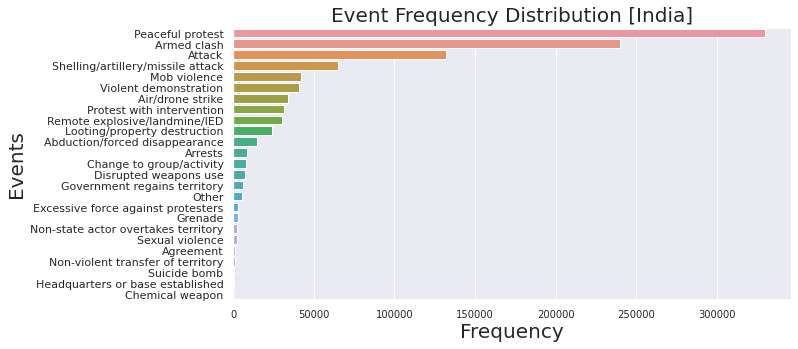

In [19]:
sns.set_theme(style="darkgrid")
x = df['sub_event_type'].value_counts()
y = x.index
plt.figure(figsize=(10, 5))
g = sns.barplot(x=x, y=y)
plt.title("Event Frequency Distribution [India]", fontsize=20)
plt.ylabel('Events', fontsize= 20)
plt.yticks(fontsize=11)
plt.xlabel('Frequency', fontsize=20)
plt.xticks(fontsize=10)
plt.show()

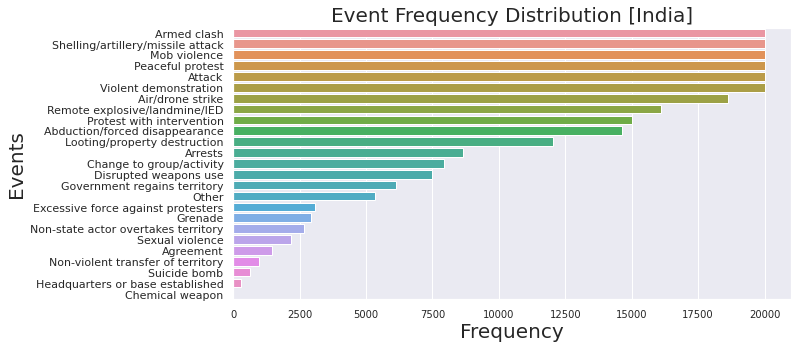

In [20]:
sns.set_theme(style="darkgrid")
x = balanced_df.Labels.value_counts()
y = x.index
plt.figure(figsize=(10, 5))
g = sns.barplot(x=x, y=y)
plt.title("Event Frequency Distribution [India]", fontsize=20)
plt.ylabel('Events', fontsize= 20)
plt.yticks(fontsize=11)
plt.xlabel('Frequency', fontsize=20)
plt.xticks(fontsize=10)
plt.show()

In [21]:
balanced_df['NumLabel'] = balanced_df.Labels.apply(text_to_numerical_category)

In [22]:
balanced_df.head()

,Text,Labels,NumLabel
0,december osce smm observed total explosion inv...,Shelling/artillery/missile attack,0
1,prohouthi force reportedly fired mortar reside...,Shelling/artillery/missile attack,0
2,ukrainian force fired ifvs position donbas peo...,Shelling/artillery/missile attack,0
3,turkish force supported jws operating ops shel...,Shelling/artillery/missile attack,0
4,opposition rebel shelled regime force position...,Shelling/artillery/missile attack,0


# BERT

### Tokenization

In [23]:
max_classes = len(balanced_df.Labels.unique())

In [24]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
result = shuffle(balanced_df)

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(balanced_df.Text, balanced_df.NumLabel, test_size = 0.1, random_state = 42, stratify =balanced_df.NumLabel)

In [26]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'
bert_model_link = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_model_preprocessing_link = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [27]:
bert_preprocess_model = hub.KerasLayer(bert_model_preprocessing_link)

In [28]:
bert_model = hub.KerasLayer(bert_model_link)


In [29]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype = tf.string, name='input-text')
    preprocessing_layer = hub.KerasLayer(bert_model_preprocessing_link, name='bert-preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(bert_model_link, trainable=True, name='bert-encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = Dense(units= 512, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.1)(net)
    net = Dense(units=max_classes, activation='softmax', name='classifer')(net)
    return tf.keras.Model(text_input, net)


In [30]:
classifier_model = build_classifier_model()
# bert_raw_result = classifier_model(tf.constant(sample_text))

In [31]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input-text (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
bert-preprocessing (KerasLayer) {'input_type_ids': ( 0           input-text[0][0]                 
__________________________________________________________________________________________________
bert-encoder (KerasLayer)       {'sequence_output':  109482241   bert-preprocessing[0][0]         
                                                                 bert-preprocessing[0][1]         
                                                                 bert-preprocessing[0][2]         
______________________________________________________________________________________________

### Label Encoding

In [33]:
max_classes = len(balanced_df.Labels.unique())

In [34]:
%%time
encoded_labels_train = to_categorical(Y_train, num_classes=max_classes)
encoded_labels_test = to_categorical(Y_test, num_classes=max_classes)

CPU times: user 8.84 ms, sys: 1.99 ms, total: 10.8 ms
Wall time: 12.1 ms


## Hyperparametrs

In [44]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay

EPOCHS = 3
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
batch_size = 32

num_train_steps =  len((balanced_df.NumLabel) // batch_size) * EPOCHS
lr_scheduler = PolynomialDecay(initial_learning_rate=5e-5,
                               end_learning_rate=0.,
                               decay_steps=num_train_steps
                               )

from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=lr_scheduler)

### Custom Callbacks

In [45]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
!mkdir checkpoints

MyCheckpoint = ModelCheckpoint('/content/checkpoints',
                               monitor = 'val_categorical_accuracy',
                               verbose = 1,
                               save_best_only = True,
                               save_weights_only = False)

MyEarlyStopping = EarlyStopping(patience =1,
                                monitor='val_categorical_accuracy',
                                restore_best_weights = True,
                                verbose = 1)

import os
os.path.exists('/content/checkpoints')

mkdir: cannot create directory ‘checkpoints’: File exists


True

## Class Weight Balancing

In [46]:
from sklearn.utils import class_weight
class_weights_array = class_weight.compute_class_weight('balanced'
                                               ,np.unique(balanced_df.NumLabel)
                                               ,balanced_df.NumLabel)

class_weights_array

array([4.92640000e-01, 4.92640000e-01, 4.92640000e-01, 4.92640000e-01,
       5.28980994e-01, 4.92640000e-01, 4.92640000e-01, 6.56459458e-01,
       3.18037444e+00, 8.18610834e-01, 1.84061274e+00, 6.11405523e-01,
       1.60260247e+00, 6.73741794e-01, 1.24325552e+00, 3.69018727e+00,
       1.13668666e+00, 4.48670310e+00, 1.31388185e+00, 9.96238625e+00,
       3.34219810e+00, 3.16810289e+01, 1.55162205e+01, 6.74849315e+00,
       9.85280000e+02])

In [47]:
class_weights = {i : class_weights_array[i] for i in range(len(class_weights_array))}
class_weights

{0: 0.49264,
 1: 0.49264,
 2: 0.49264,
 3: 0.49264,
 4: 0.5289809943090303,
 5: 0.49264,
 6: 0.49264,
 7: 0.6564594576587381,
 8: 3.180374435119432,
 9: 0.8186108341641741,
 10: 1.8406127405193349,
 11: 0.6114055228048402,
 12: 1.6026024723487313,
 13: 0.6737417943107221,
 14: 1.2432555205047318,
 15: 3.690187265917603,
 16: 1.1366866635902169,
 17: 4.486703096539162,
 18: 1.313881850913455,
 19: 9.962386248736097,
 20: 3.342198100407056,
 21: 31.681028938906753,
 22: 15.516220472440946,
 23: 6.748493150684932,
 24: 985.28}

## Building Model

### Defining Model Metrics

In [48]:
# !pip install tensorflow_addons
import tensorflow_addons as tfa

macro_f1 = tfa.metrics.F1Score(num_classes=max_classes, average='macro')
micro_f1 = tfa.metrics.F1Score(num_classes=max_classes, average='micro')
weighted_f1 = tfa.metrics.F1Score(num_classes=max_classes, average='weighted')
precision = tf.metrics.Precision()
recall = tf.metrics.Recall()
categorical_accuracry = tf.metrics.CategoricalAccuracy()

metrics = [categorical_accuracry, micro_f1, precision, recall]


## Model Compiling

In [49]:
classifier_model.compile(optimizer= opt,
              loss= loss,
              metrics = metrics)

In [50]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, encoded_labels_train)).shuffle(70000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, encoded_labels_test)).shuffle(70000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

## Model Training

In [51]:
classifier_model.fit(train_dataset,
                     validation_data=test_dataset,
                 epochs = EPOCHS,
                 verbose = 1,
                 class_weight=class_weights,
                 callbacks = [MyCheckpoint, MyEarlyStopping]
          )

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Epoch 1/3
6928/6928 [==============================] - ETA: 0s - loss: 0.9719 - categorical_accuracy: 0.7981 - f1_score: 0.7981 - precision_1: 0.8831 - recall_1: 0.7406

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


6928/6928 [==============================] - 6172s 889ms/step - loss: 0.9719 - categorical_accuracy: 0.7981 - f1_score: 0.7981 - precision_1: 0.8831 - recall_1: 0.7406 - val_loss: 0.5043 - val_categorical_accuracy: 0.8644 - val_f1_score: 0.8644 - val_precision_1: 0.8902 - val_recall_1: 0.8372

Epoch 00001: val_categorical_accuracy improved from -inf to 0.86436, saving model to /content/checkpoints


INFO:tensorflow:Assets written to: /content/checkpoints/assets


INFO:tensorflow:Assets written to: /content/checkpoints/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


Epoch 2/3
6928/6928 [==============================] - 6162s 889ms/step - loss: 0.6426 - categorical_accuracy: 0.8658 - f1_score: 0.8658 - precision_1: 0.8993 - recall_1: 0.8407 - val_loss: 0.3054 - val_categorical_accuracy: 0.9116 - val_f1_score: 0.9116 - val_precision_1: 0.9223 - val_recall_1: 0.9024

Epoch 00002: val_categorical_accuracy improved from 0.86436 to 0.91158, saving model to /content/checkpoints


INFO:tensorflow:Assets written to: /content/checkpoints/assets


INFO:tensorflow:Assets written to: /content/checkpoints/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


Epoch 3/3
6928/6928 [==============================] - 6177s 892ms/step - loss: 0.6411 - categorical_accuracy: 0.8774 - f1_score: 0.8774 - precision_1: 0.9130 - recall_1: 0.8567 - val_loss: 0.3348 - val_categorical_accuracy: 0.9081 - val_f1_score: 0.9081 - val_precision_1: 0.9187 - val_recall_1: 0.9016

Epoch 00003: val_categorical_accuracy did not improve from 0.91158
Restoring model weights from the end of the best epoch.
Epoch 00003: early stopping


In [59]:
import matplotlib.pyplot as plt 
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "categorical_accuracy")
plot_graphs(history, 'loss')


NameError: ignored

In [53]:
classifier_model.save('BERT-Model.h5')

In [57]:
test_file = pd.read_csv('/content/test_set_final_release.tsv', sep='\t')

In [58]:
test_file.head()

,id,EventSnippet
0,1,The US warplanes pounded the village of Kashka...
1,2,After a five-week drop of Covid-19 cases in Pu...
2,3,Officers brutally attacked and injured a peace...
3,4,"On December 13, ISIS fighters recaptured the v..."
4,5,Vice-President Mike Pence said Thursday that t...


In [68]:
# Remove Excess [Size:: ] from EoS
def remove_size(text):
	result = re.search("\[size", text)
	if result is not None:
		text = text[:result.start()]
	return text.strip()

months = ['january', 'jan', 'feb', 'mar', 'apr', 'aug', 'sept', 'oct', 'nov', 'dec', 'feburary', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december', 'on']
def remove_months(text):
    text = text.split()
    text = [word for word in text if word.lower() not in set(months)]
    text = ' '.join(text)
    return text

def remove_nums(text):
    result = re.sub(r'[0-9+]', '', text)
    return result

def remove_comma(text):
    result = re.sub(r',', '', text)
    return result


In [69]:
def text_cleaning(text):
    text = remove_size(text)
    text = remove_nums(text)
    text = remove_months(text)
    text = remove_comma(text)
    return text.strip().lower()

test_file['processed'] = test_file['EventSnippet'].apply(text_cleaning)

In [66]:
lemmatizer = WordNetLemmatizer()
from nltk import word_tokenize, WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
def lemmatizing_headlines(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in set(stopwords.words('english'))]
    return ' '.join(tokens).strip()

test_file['processed'] = test_file['processed'].apply(lemmatizing_headlines)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [70]:
test_file.head()

,id,EventSnippet,processed
0,1,The US warplanes pounded the village of Kashka...,the us warplanes pounded the village of kashka...
1,2,After a five-week drop of Covid-19 cases in Pu...,after a five-week drop of covid- cases in punj...
2,3,Officers brutally attacked and injured a peace...,officers brutally attacked and injured a peace...
3,4,"On December 13, ISIS fighters recaptured the v...",isis fighters recaptured the village of kashma...
4,5,Vice-President Mike Pence said Thursday that t...,vice-president mike pence said thursday that t...


In [75]:
y_preds = np.argmax(classifier_model.predict(test_file.processed), axis=1)

In [76]:
y_preds

array([ 4, 10,  8, ...,  5, 16, 19])

In [77]:
test_file['pred-labels'] = y_preds

In [81]:
test_file.head()

,id,EventSnippet,processed,pred-labels,text-labels
0,1,The US warplanes pounded the village of Kashka...,the us warplanes pounded the village of kashka...,4,Air/drone strike
1,2,After a five-week drop of Covid-19 cases in Pu...,after a five-week drop of covid- cases in punj...,10,Other
2,3,Officers brutally attacked and injured a peace...,officers brutally attacked and injured a peace...,8,Excessive force against protesters
3,4,"On December 13, ISIS fighters recaptured the v...",isis fighters recaptured the village of kashma...,15,Non-state actor overtakes territory
4,5,Vice-President Mike Pence said Thursday that t...,vice-president mike pence said thursday that t...,23,Agreement


In [80]:
def num_to_text_labels(num):
    text = event_types_dict_inverse[num]
    return text

test_file['text-labels'] = test_file['pred-labels'].apply(num_to_text_labels)

In [82]:
correct_format = ['ABDUCT_DISSAP',
'AGREEMENT',
'AIR_STRIKE',
'ARMED_CLASH',
'ARREST',
'ART_MISS_ATTACK',
'ATTACK',
'CHANGE_TO_GROUP_ACT',
'CHEM_WEAP',
'DISR_WEAP',
'FORCE_AGAINST_PROTEST',
'GOV_REGAINS_TERIT',
'GRENADE',
'HQ_ESTABLISHED',
'MOB_VIOL',
'NON_STATE_ACTOR_OVERTAKES_TER',
'NON_VIOL_TERRIT_TRANSFER',
'OTHER',
'PEACE_PROTEST',
'PROPERTY_DISTRUCT',
'PROTEST_WITH_INTER',
'REM_EXPLOS',
'SEX_VIOL',
'SUIC_BOMB',
'VIOL_DEMONSTR']

In [92]:
dict_list = list(event_types_dict.keys())

In [98]:
dict_list

correct_format_dict = {'Abduction/forced disappearance':'ABDUCT_DISSAP',
                       'Agreement': 'AGREEMENT',
                        'Air/drone strike' : 'AIR_STRIKE',
                         'Armed clash' : 'ARMED_CLASH',
                       'Arrests' : 'ARREST',
                       'Attack' : 'ATTACK',
                       'Change to group/activity' : 'CHANGE_TO_GROUP_ACT',
                       'Chemical weapon' : 'CHEM_WEAP',
                       'Disrupted weapons use' : 'DISR_WEAP',
                       'Excessive force against protesters' : 'FORCE_AGAINST_PROTEST',
                       'Government regains territory' : 'GOV_REGAINS_TERIT',
                       'Grenade' : 'GRENADE',
                        'Headquarters or base established' : 'HQ_ESTABLISHED',
                       'Looting/property destruction' : 'PROPERTY_DISTRUCT',
                       'Mob violence' : 'MOB_VIOL',
                       'Non-state actor overtakes territory' : 'NON_STATE_ACTOR_OVERTAKES_TER',
                       'Non-violent transfer of territory' : 'NON_VIOL_TERRIT_TRANSFER',
                       'Other' : 'OTHER',
                        'Peaceful protest' : 'PEACE_PROTEST',
                       'Protest with intervention' : 'PROTEST_WITH_INTER',
                       'Remote explosive/landmine/IED' : 'REM_EXPLOS',
                       'Sexual violence' : 'SEX_VIOL',
                       'Shelling/artillery/missile attack' : 'ART_MISS_ATTACK',
                       'Suicide bomb' : 'SUIC_BOMB',
                        'Violent demonstration' : 'VIOL_DEMONSTR'
                       }

In [99]:
correct_format_dict

{'Abduction/forced disappearance': 'ABDUCT_DISSAP',
 'Agreement': 'AGREEMENT',
 'Air/drone strike': 'AIR_STRIKE',
 'Armed clash': 'ARMED_CLASH',
 'Arrests': 'ARREST',
 'Attack': 'ATTACK',
 'Change to group/activity': 'CHANGE_TO_GROUP_ACT',
 'Chemical weapon': 'CHEM_WEAP',
 'Disrupted weapons use': 'DISR_WEAP',
 'Excessive force against protesters': 'FORCE_AGAINST_PROTEST',
 'Government regains territory': 'GOV_REGAINS_TERIT',
 'Grenade': 'GRENADE',
 'Headquarters or base established': 'HQ_ESTABLISHED',
 'Looting/property destruction': 'PROPERTY_DISTRUCT',
 'Mob violence': 'MOB_VIOL',
 'Non-state actor overtakes territory': 'NON_STATE_ACTOR_OVERTAKES_TER',
 'Non-violent transfer of territory': 'NON_VIOL_TERRIT_TRANSFER',
 'Other': 'OTHER',
 'Peaceful protest': 'PEACE_PROTEST',
 'Protest with intervention': 'PROTEST_WITH_INTER',
 'Remote explosive/landmine/IED': 'REM_EXPLOS',
 'Sexual violence': 'SEX_VIOL',
 'Shelling/artillery/missile attack': 'ART_MISS_ATTACK',
 'Suicide bomb': 'SUIC_B

In [101]:
def correct_format(text):
    correct_label = correct_format_dict[text]
    return correct_label

test_file['correct-labels'] = test_file['text-labels'].apply(correct_format)

In [102]:
test_file.head()

,id,EventSnippet,processed,pred-labels,text-labels,correct-labels
0,1,The US warplanes pounded the village of Kashka...,the us warplanes pounded the village of kashka...,4,Air/drone strike,AIR_STRIKE
1,2,After a five-week drop of Covid-19 cases in Pu...,after a five-week drop of covid- cases in punj...,10,Other,OTHER
2,3,Officers brutally attacked and injured a peace...,officers brutally attacked and injured a peace...,8,Excessive force against protesters,FORCE_AGAINST_PROTEST
3,4,"On December 13, ISIS fighters recaptured the v...",isis fighters recaptured the village of kashma...,15,Non-state actor overtakes territory,NON_STATE_ACTOR_OVERTAKES_TER
4,5,Vice-President Mike Pence said Thursday that t...,vice-president mike pence said thursday that t...,23,Agreement,AGREEMENT


In [108]:
test_file = test_file.drop(columns=['EventSnippet', 'processed', 'pred-labels', 'text-labels'])

In [113]:
test_file.to_csv('final.tsv', sep='\t', index=False)

In [114]:
trrr = pd.read_csv('final.tsv', sep='\t')

In [115]:
trrr.head()

,id,correct-labels
0,1,AIR_STRIKE
1,2,OTHER
2,3,FORCE_AGAINST_PROTEST
3,4,NON_STATE_ACTOR_OVERTAKES_TER
4,5,AGREEMENT
